# 1. Install scikit-learn & required library
This project require numpy, pandas, matplotlib,... and scikit-learn be installed. Run the following code to install the requirements.

In [1]:
from IPython.core.pylabtools import figsize
!python -m pip install -U scikit-learn
!python -m pip show scikit-learn
!python -c "import sklearn; sklearn.show_versions()"
!python -m pip install matplotlib
!python -m pip install graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

# 2. Preparing the datasets
The following code will download the dataset heart-disease from URL.

• Binary class dataset: The [UCI Heart Disease dataset](https://archive.ics.uci.edu/dataset/45/heart+disease) is used for classifying whether a
patient has a heart disease or not based on age, blood pressure, cholesterol level, and other
medical indicators. This dataset includes 303 samples, with labels indicating presence (1) or
absence (0) of heart disease. Experiments with the Cleveland database have concentrated on
simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

The dataset will be fetched from URL then split into `feature` and `label`.

In [2]:
heart_disease_db_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
dataset_name = "Heart Disease"

def split_dataset(_dataset: pd.DataFrame, targets: list):
	"""
	Split input dataset into feature and target by input targets
	:return: dict["feature"]
	"""
	existing_columns = [col for col in targets if col in _dataset.columns]
	missing_columns = [col for col in targets if col not in _dataset.columns]
	if missing_columns:
		print("These columns are not found in the dataset:", missing_columns)
	return {
		"feature": _dataset.drop(existing_columns, axis=1),
		"target": _dataset[existing_columns],
	}

# fetch dataset from url
raw_heart_db = pd.read_csv(heart_disease_db_url, names=heart_disease_columns)
raw_heart_db = raw_heart_db.replace('?', np.nan)
raw_heart_db = raw_heart_db.dropna()
raw_heart_db = raw_heart_db.astype(float)
raw_heart_db['num'] = raw_heart_db['num'].apply(lambda x: 1 if x > 0 else 0) # labelling the target 'num'

dataset = split_dataset(raw_heart_db, targets=['num'])  # adding columns name

# 3. Prepare, Building and Evaluating with the decision tree
> Required to run the code at [Section #2](#2-preparing-the-datasets) before continue!
### 3.1 Prepare the splits for the building of the decision tree
This following code splits the dataset into multiple splits with defined ratio.
The splits are structured as following `[ratio: float => (feature_train, feature_test, label_train, label_test)]`

In [3]:
from sklearn.model_selection import train_test_split

split_ratios = [0.6, 0.4, 0.2, 0.1] # train/test 60/40 40/60 80/20 90/10
random_seed = 42                    # 42 for testing and cultural reference :)
class_name = ["No Decease", "Decease"]

def prepare_dataset(features, labels, test_size, seed=None):
	"""
	:param features: input features
	:param labels: input labels
	:param test_size: Test size ratio (test/(train+test))
	:param seed: seed used for random, default=None for random seed
	:return: feature_train, feature_test, label_train, label_test
	"""
	return train_test_split(features, labels, test_size=test_size, stratify=labels, random_state=seed, shuffle=True)

def prepare_all_splits(features, labels, seed=None):
    splits = {}
    for split_ratio in split_ratios:
        splits[split_ratio] = prepare_dataset(features, labels, test_size=split_ratio, seed=seed)
    return splits

dataset_splits = prepare_all_splits(dataset['feature'], dataset['target'], seed=random_seed)

## 3.2 Training

In [4]:
from sklearn.tree import DecisionTreeClassifier

def train_and_evaluate(feature_train, label_train, max_depth=None) -> DecisionTreeClassifier:
	dtc = DecisionTreeClassifier(criterion='entropy', random_state=random_seed, max_depth=max_depth)
	dtc.fit(feature_train, label_train) # train
	return dtc

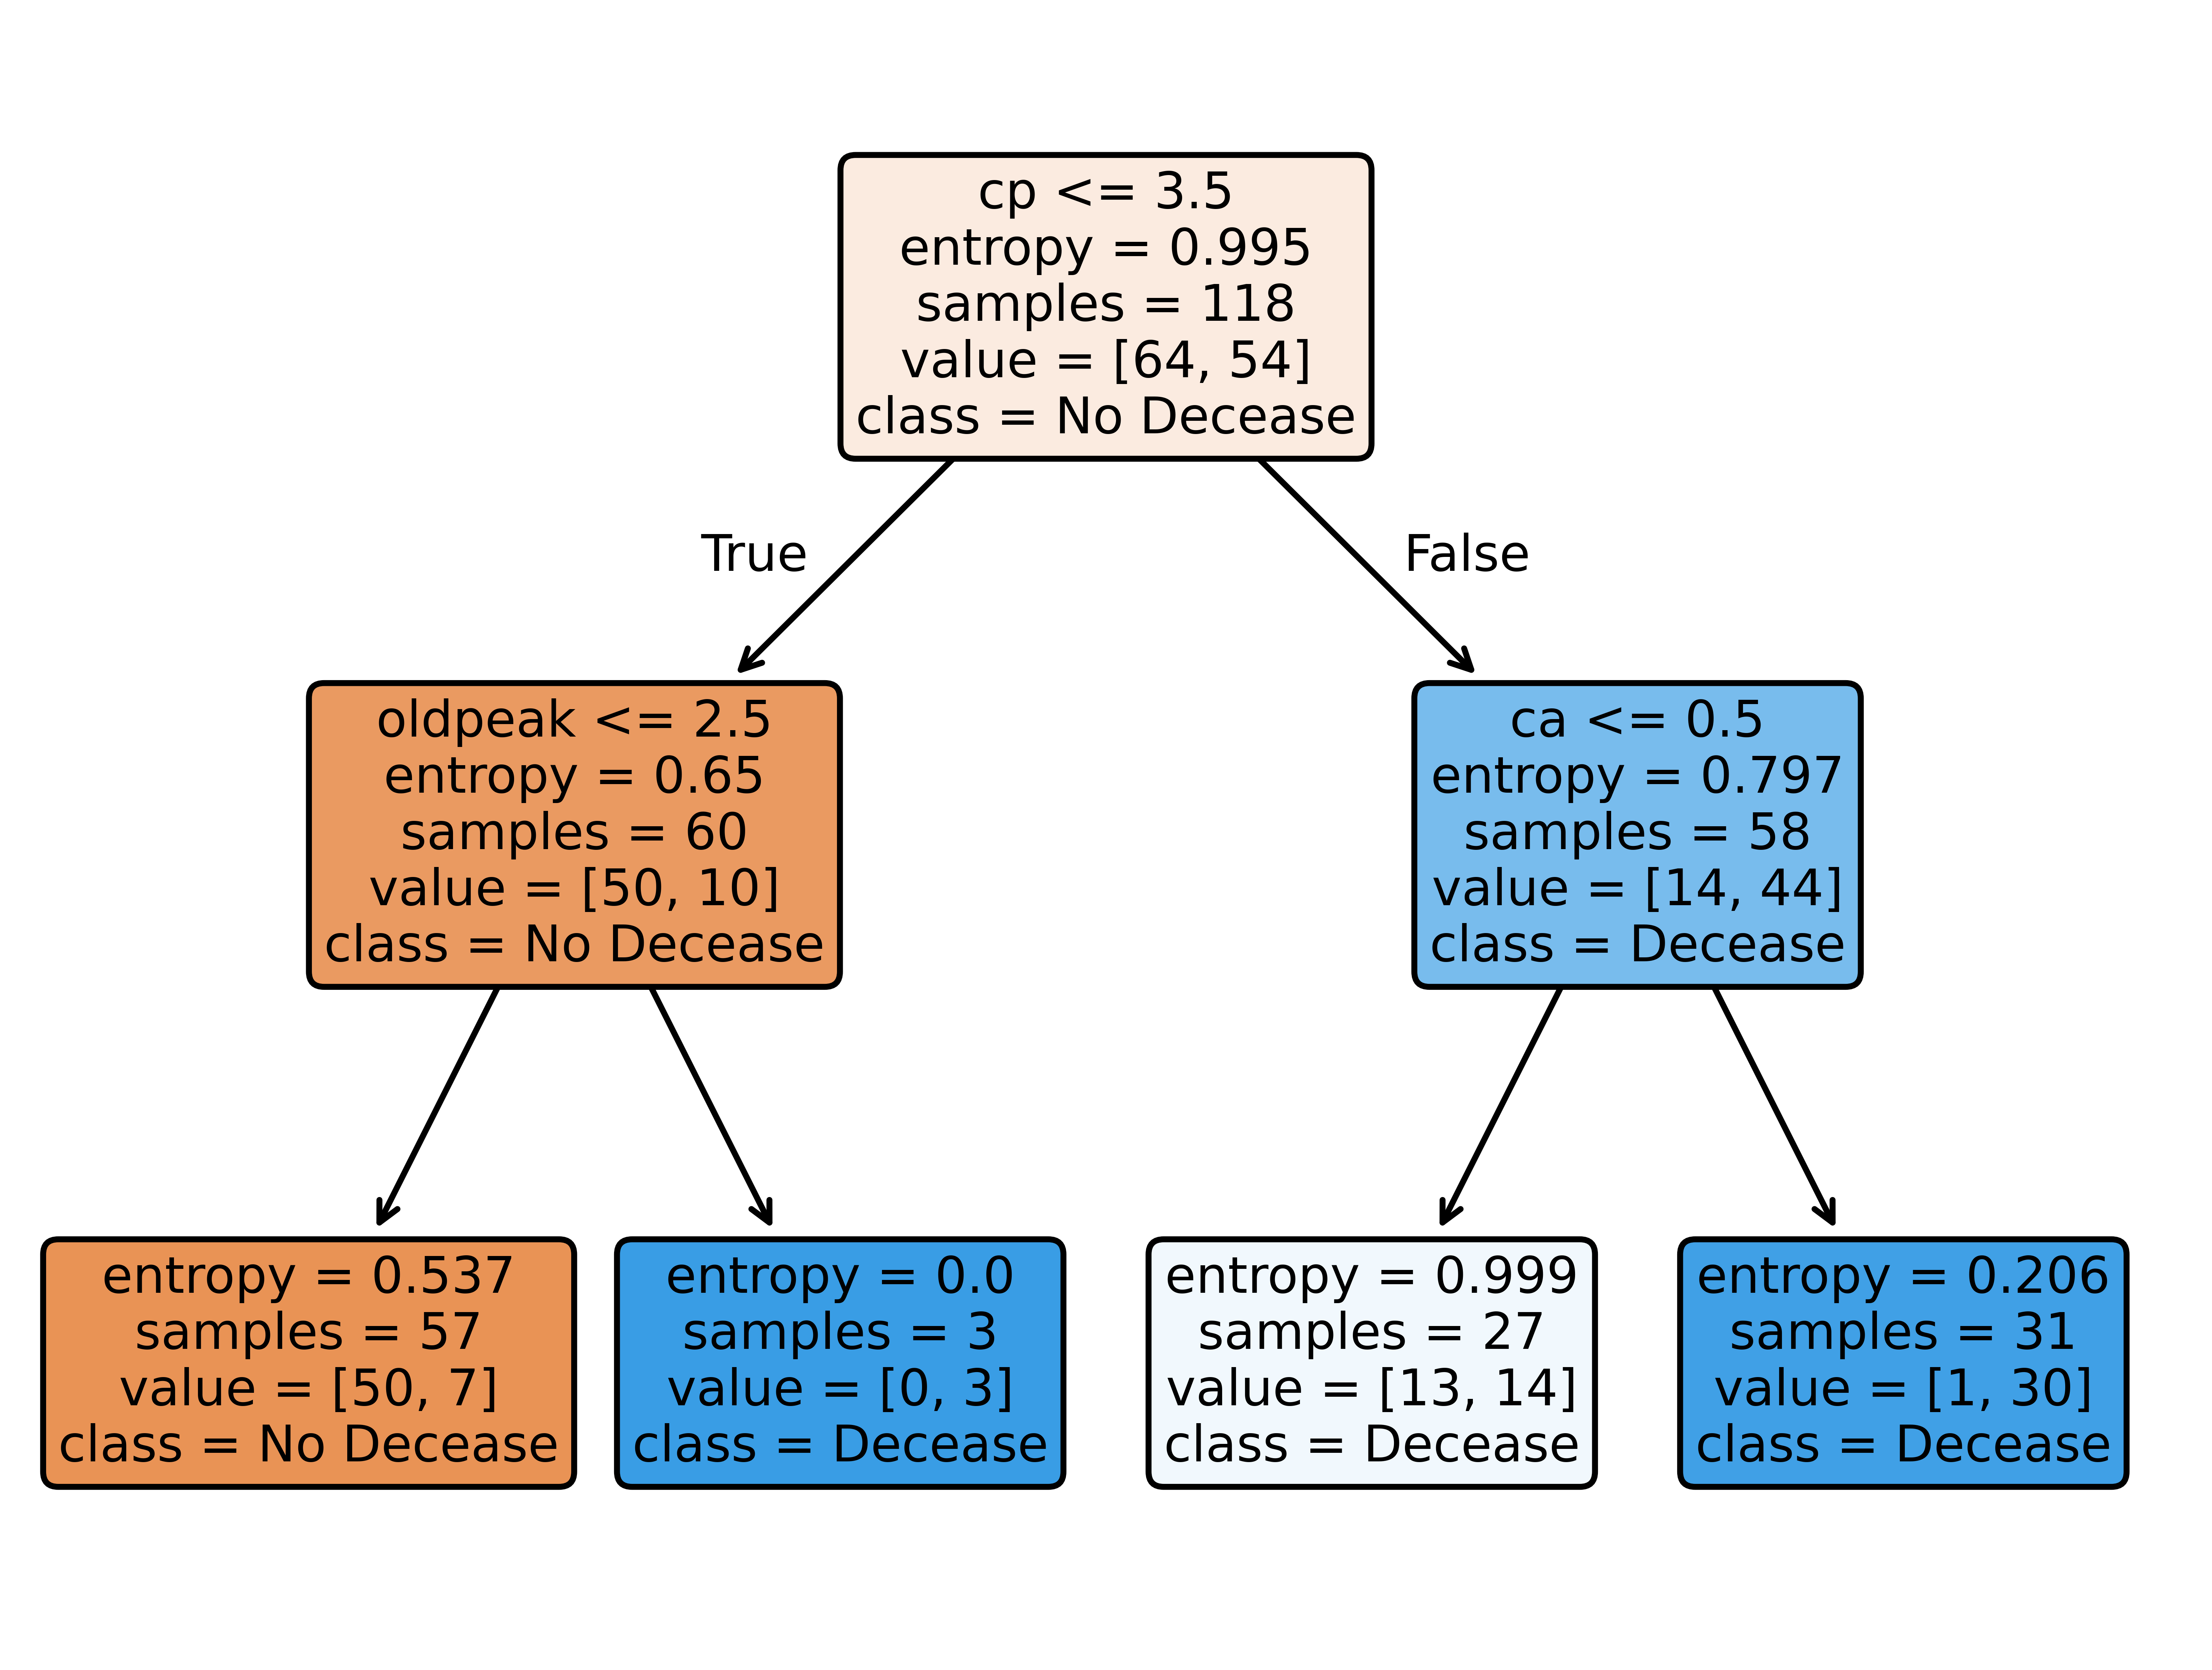


=== Heart Disease Train/Test 40/60 ===
              precision    recall  f1-score   support

  No Decease       0.76      0.71      0.74        96
     Decease       0.69      0.75      0.72        83

    accuracy                           0.73       179
   macro avg       0.73      0.73      0.73       179
weighted avg       0.73      0.73      0.73       179



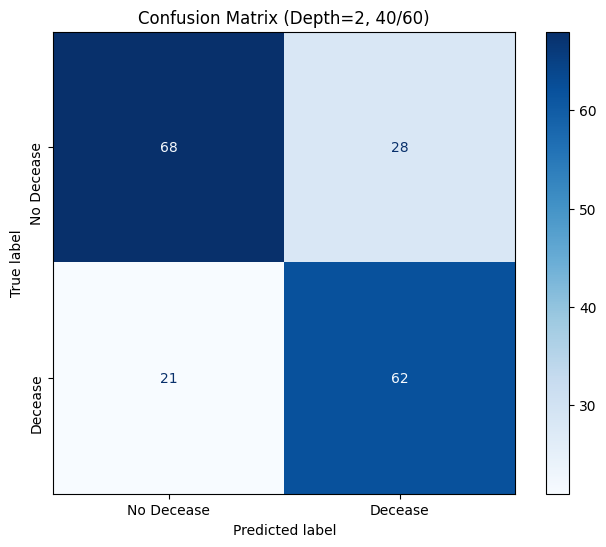

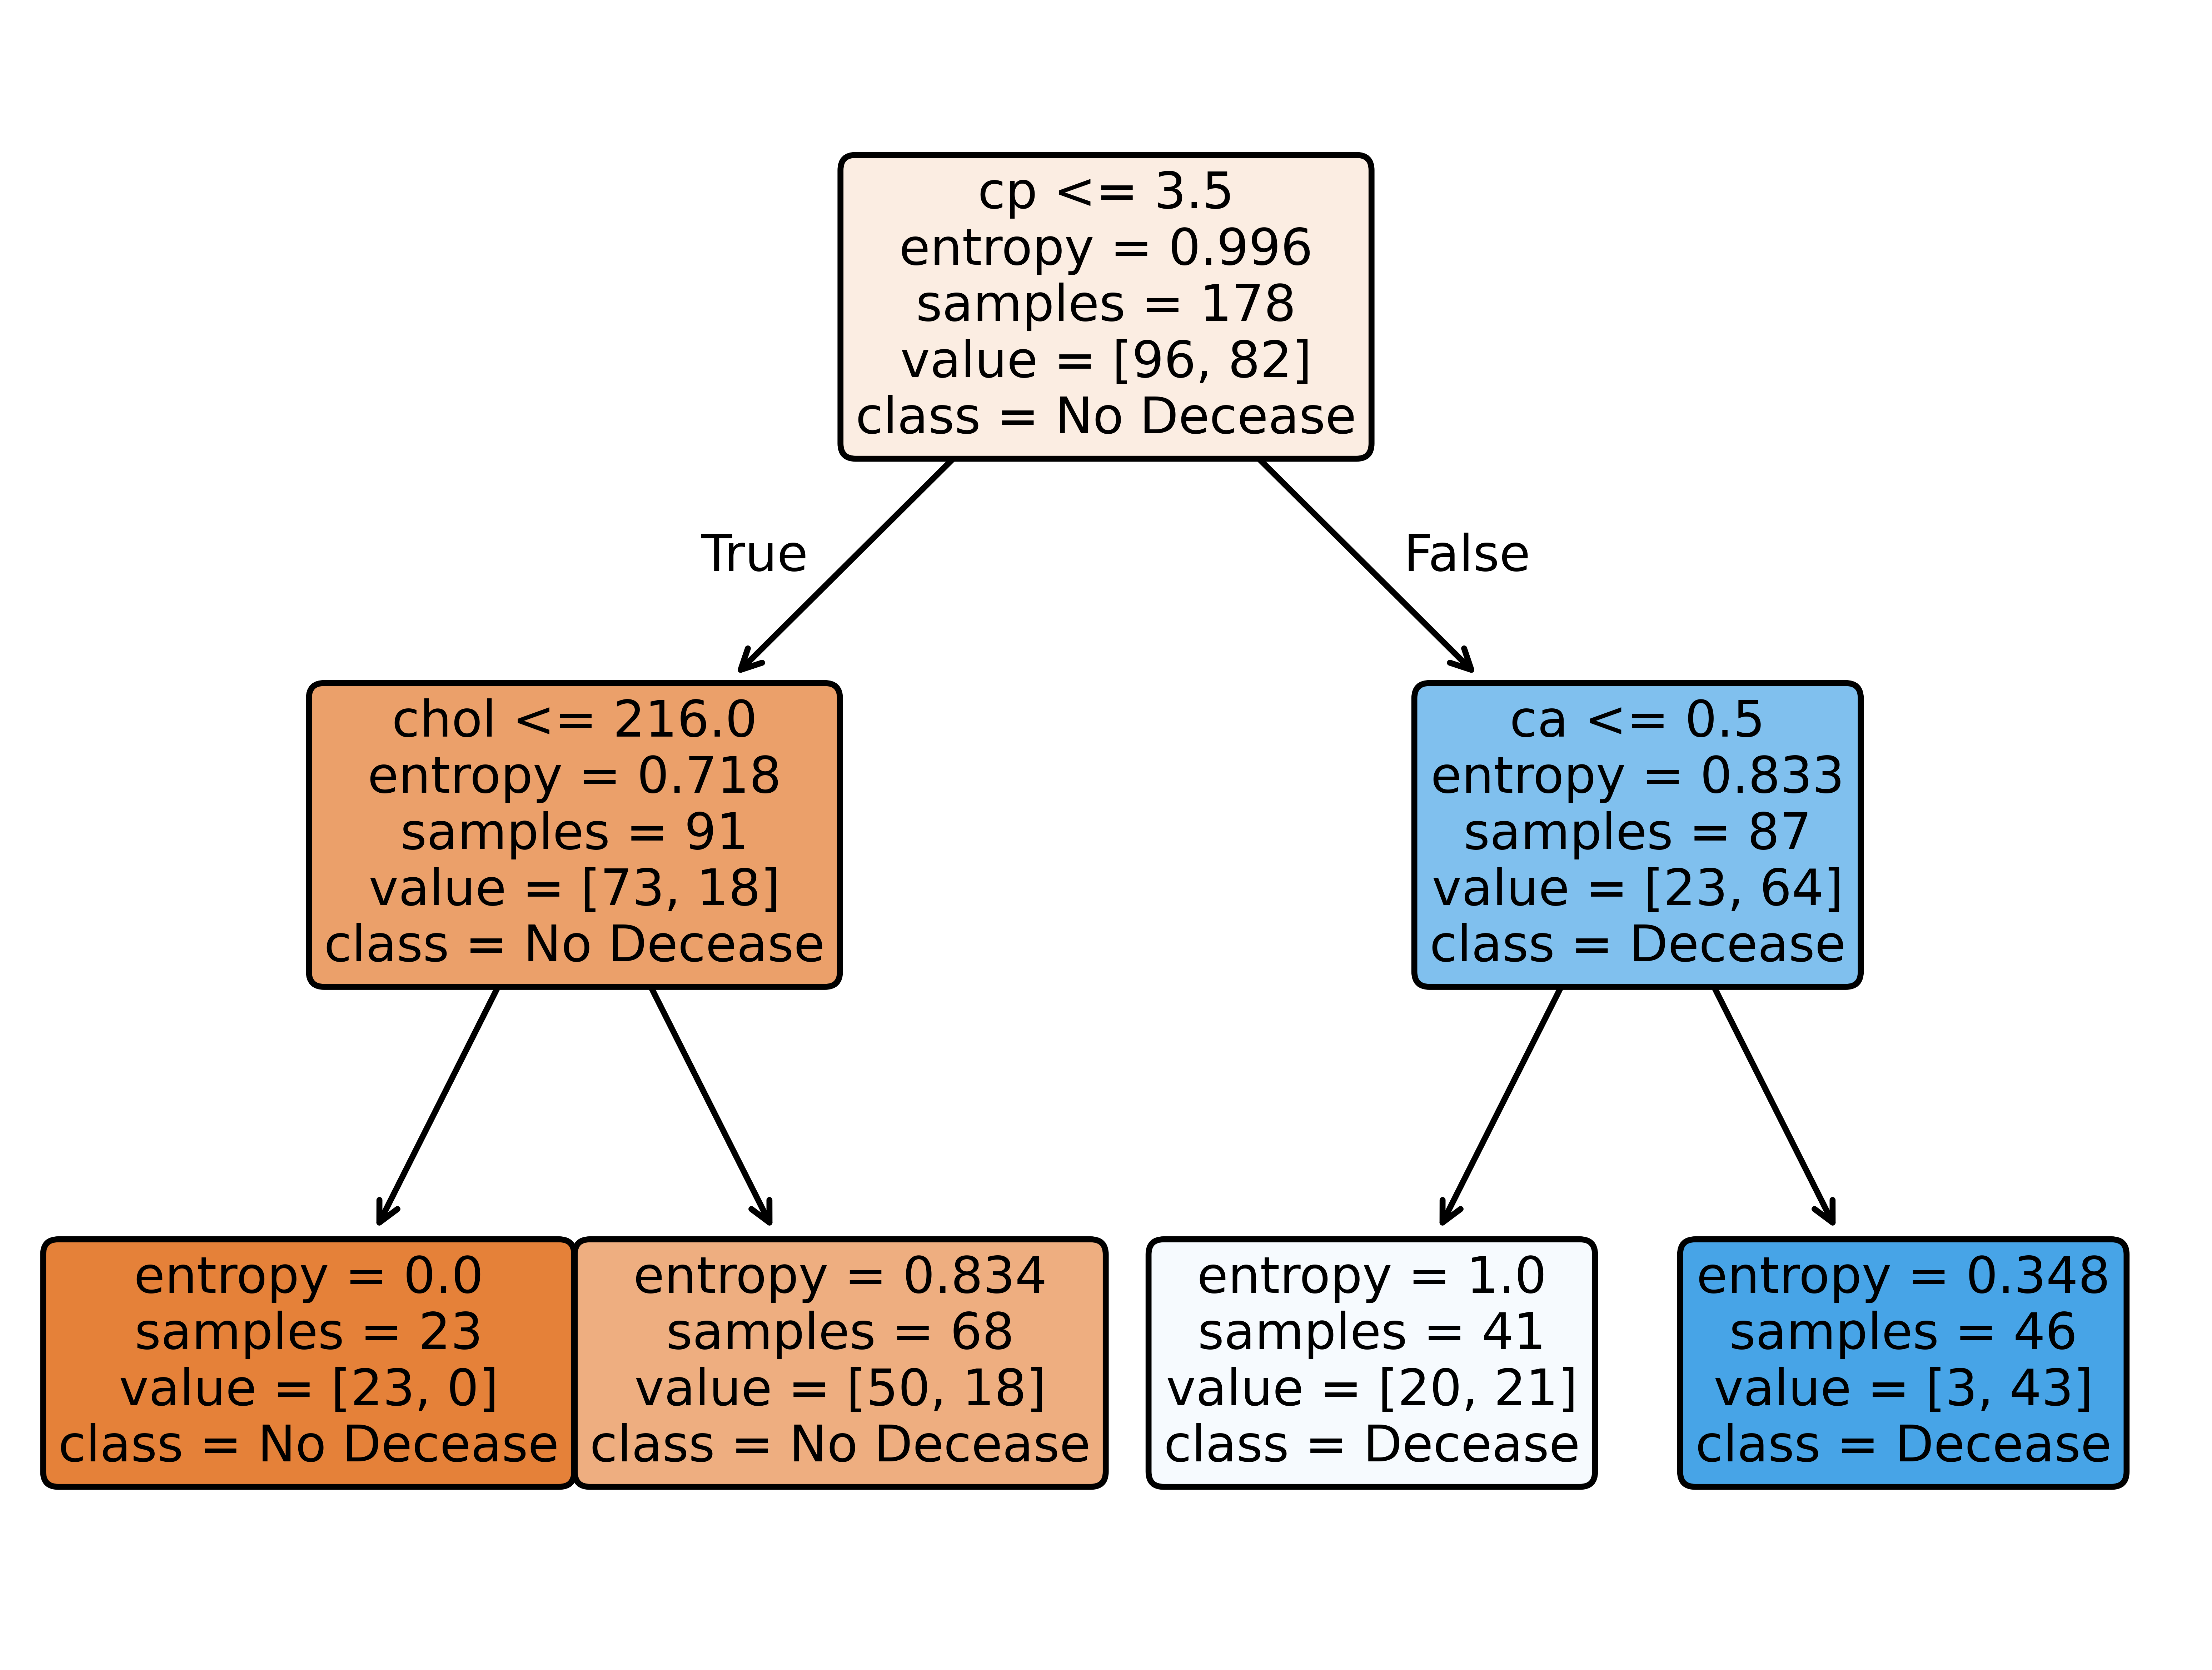


=== Heart Disease Train/Test 60/40 ===
              precision    recall  f1-score   support

  No Decease       0.75      0.75      0.75        64
     Decease       0.71      0.71      0.71        55

    accuracy                           0.73       119
   macro avg       0.73      0.73      0.73       119
weighted avg       0.73      0.73      0.73       119



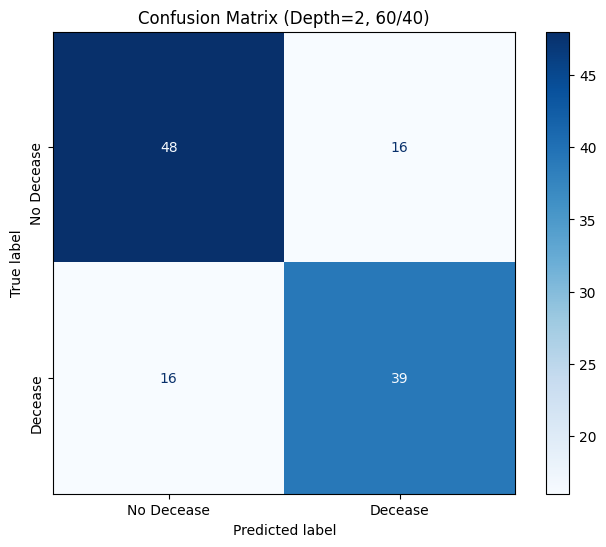

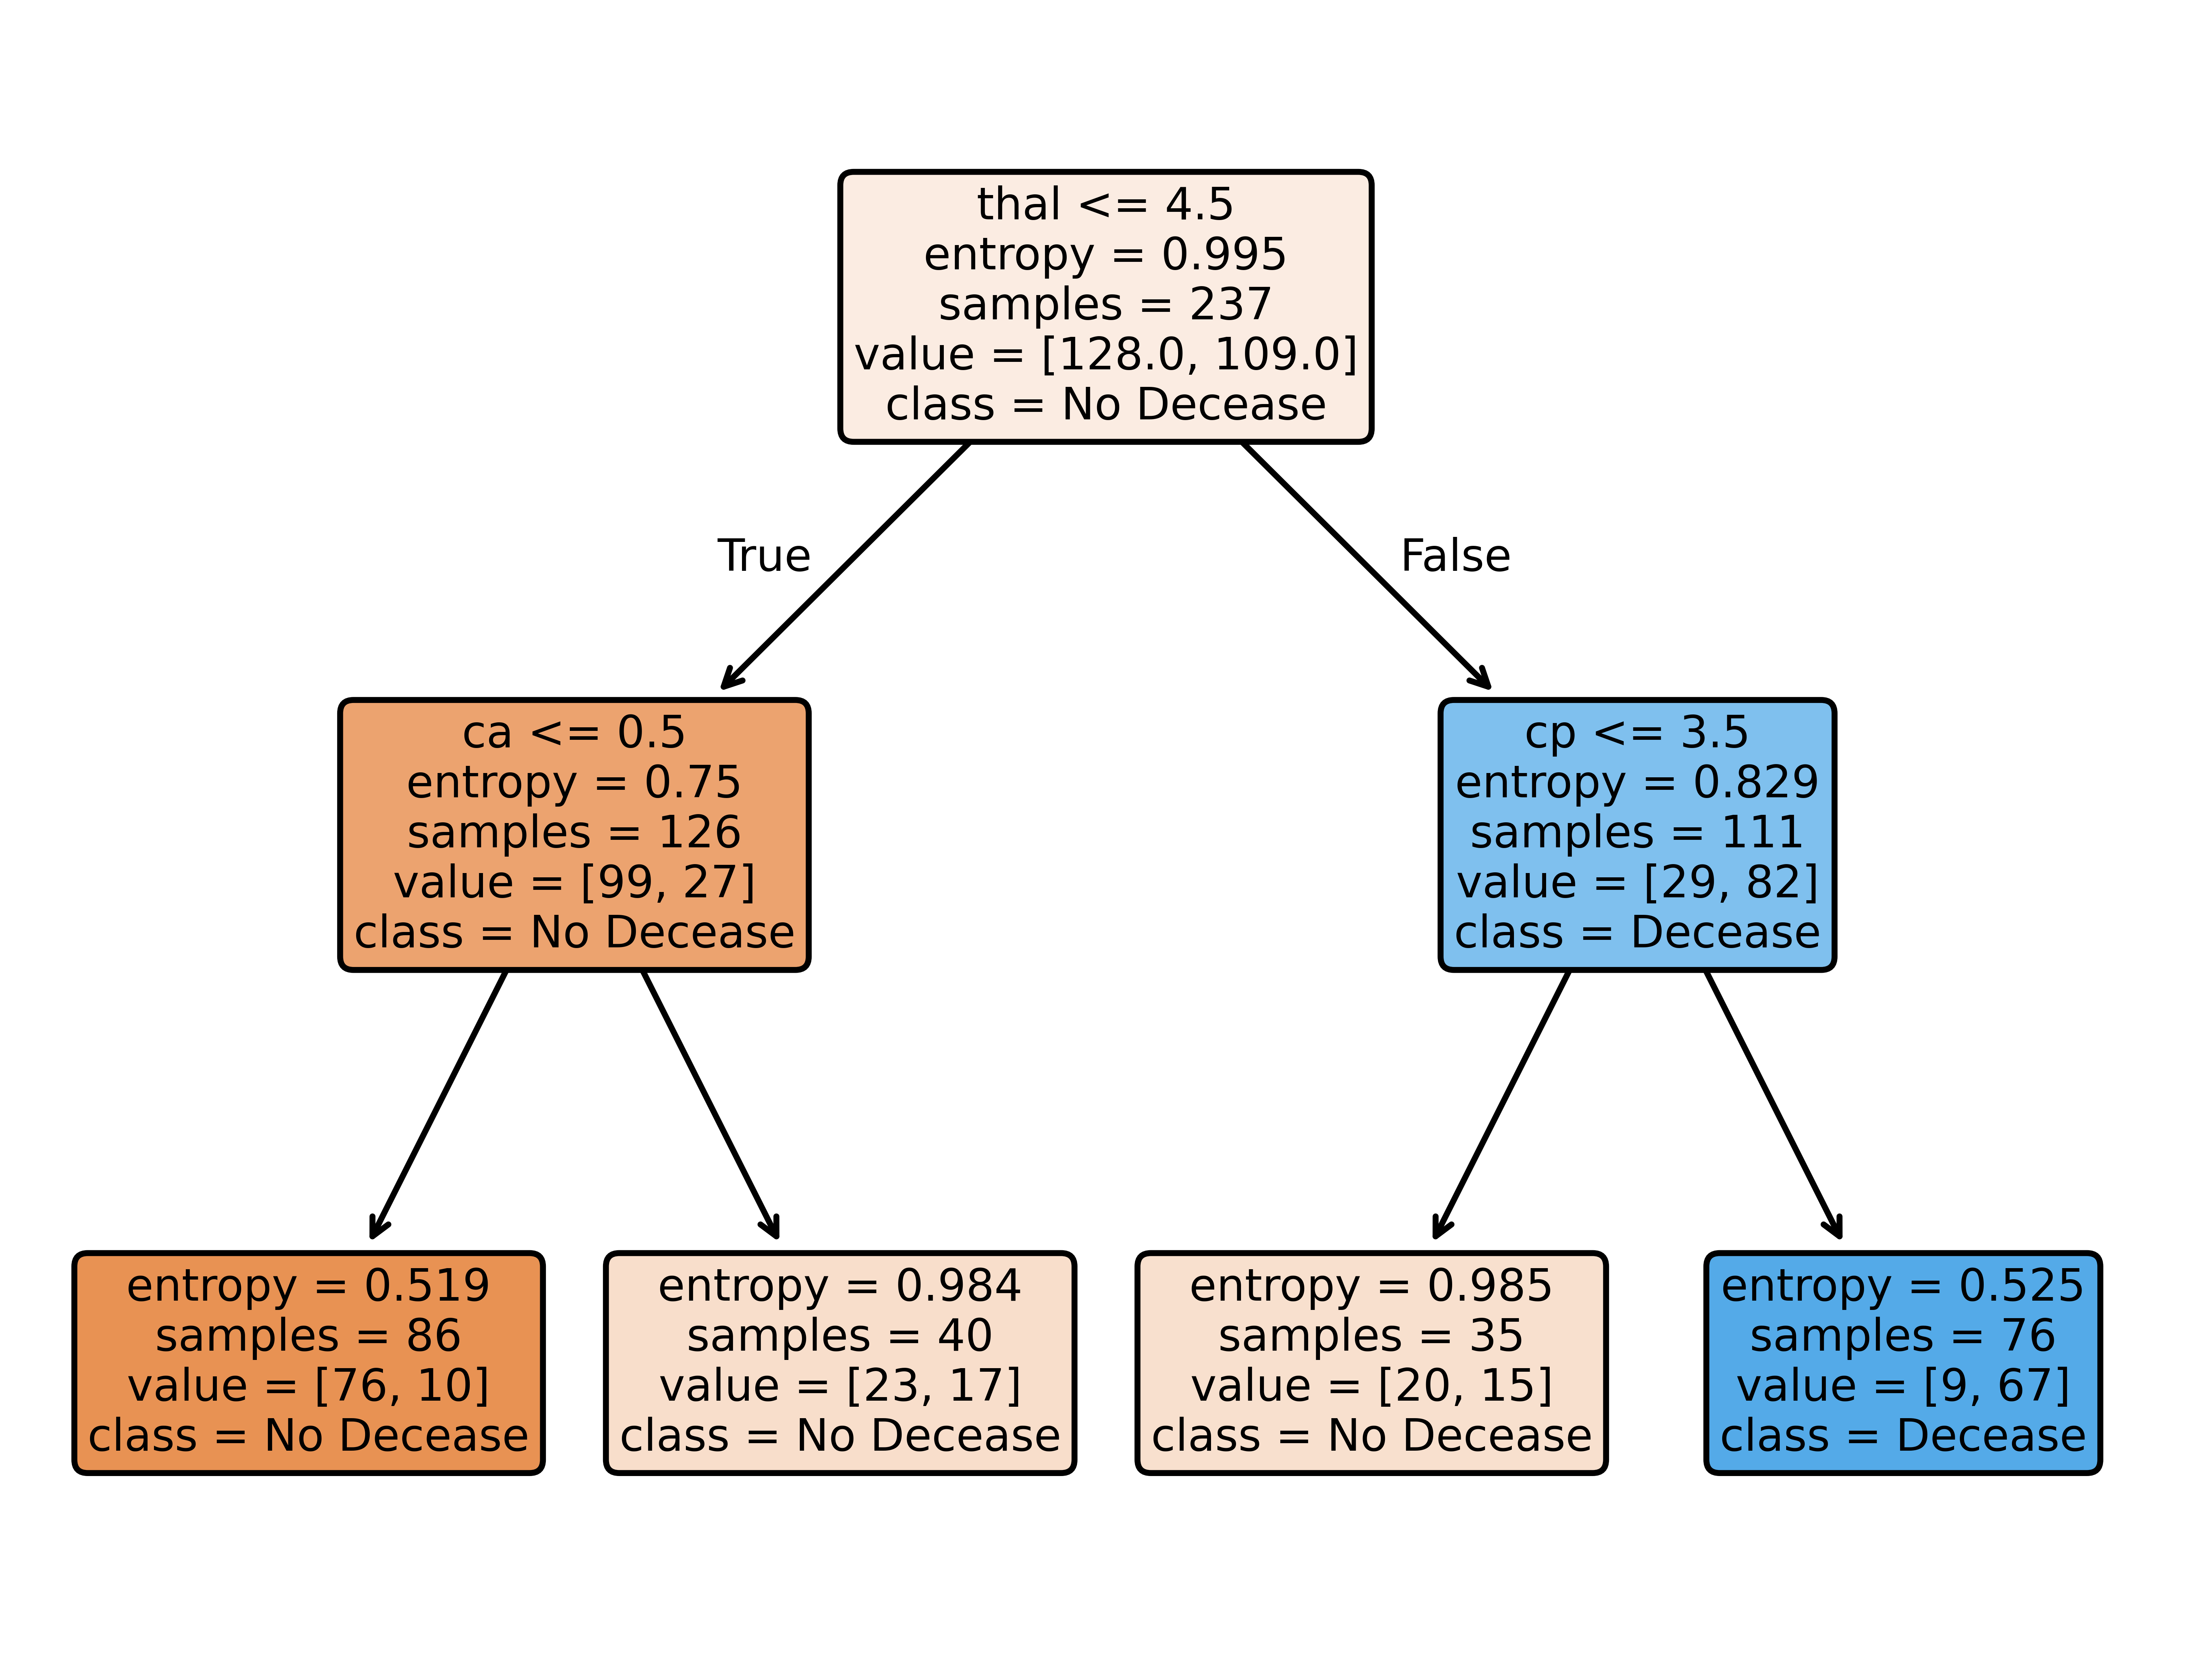


=== Heart Disease Train/Test 80/20 ===
              precision    recall  f1-score   support

  No Decease       0.66      0.97      0.78        32
     Decease       0.92      0.43      0.59        28

    accuracy                           0.72        60
   macro avg       0.79      0.70      0.69        60
weighted avg       0.78      0.72      0.69        60



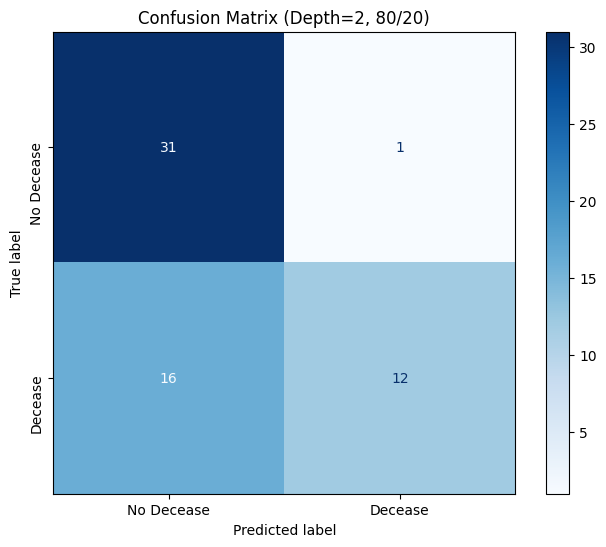

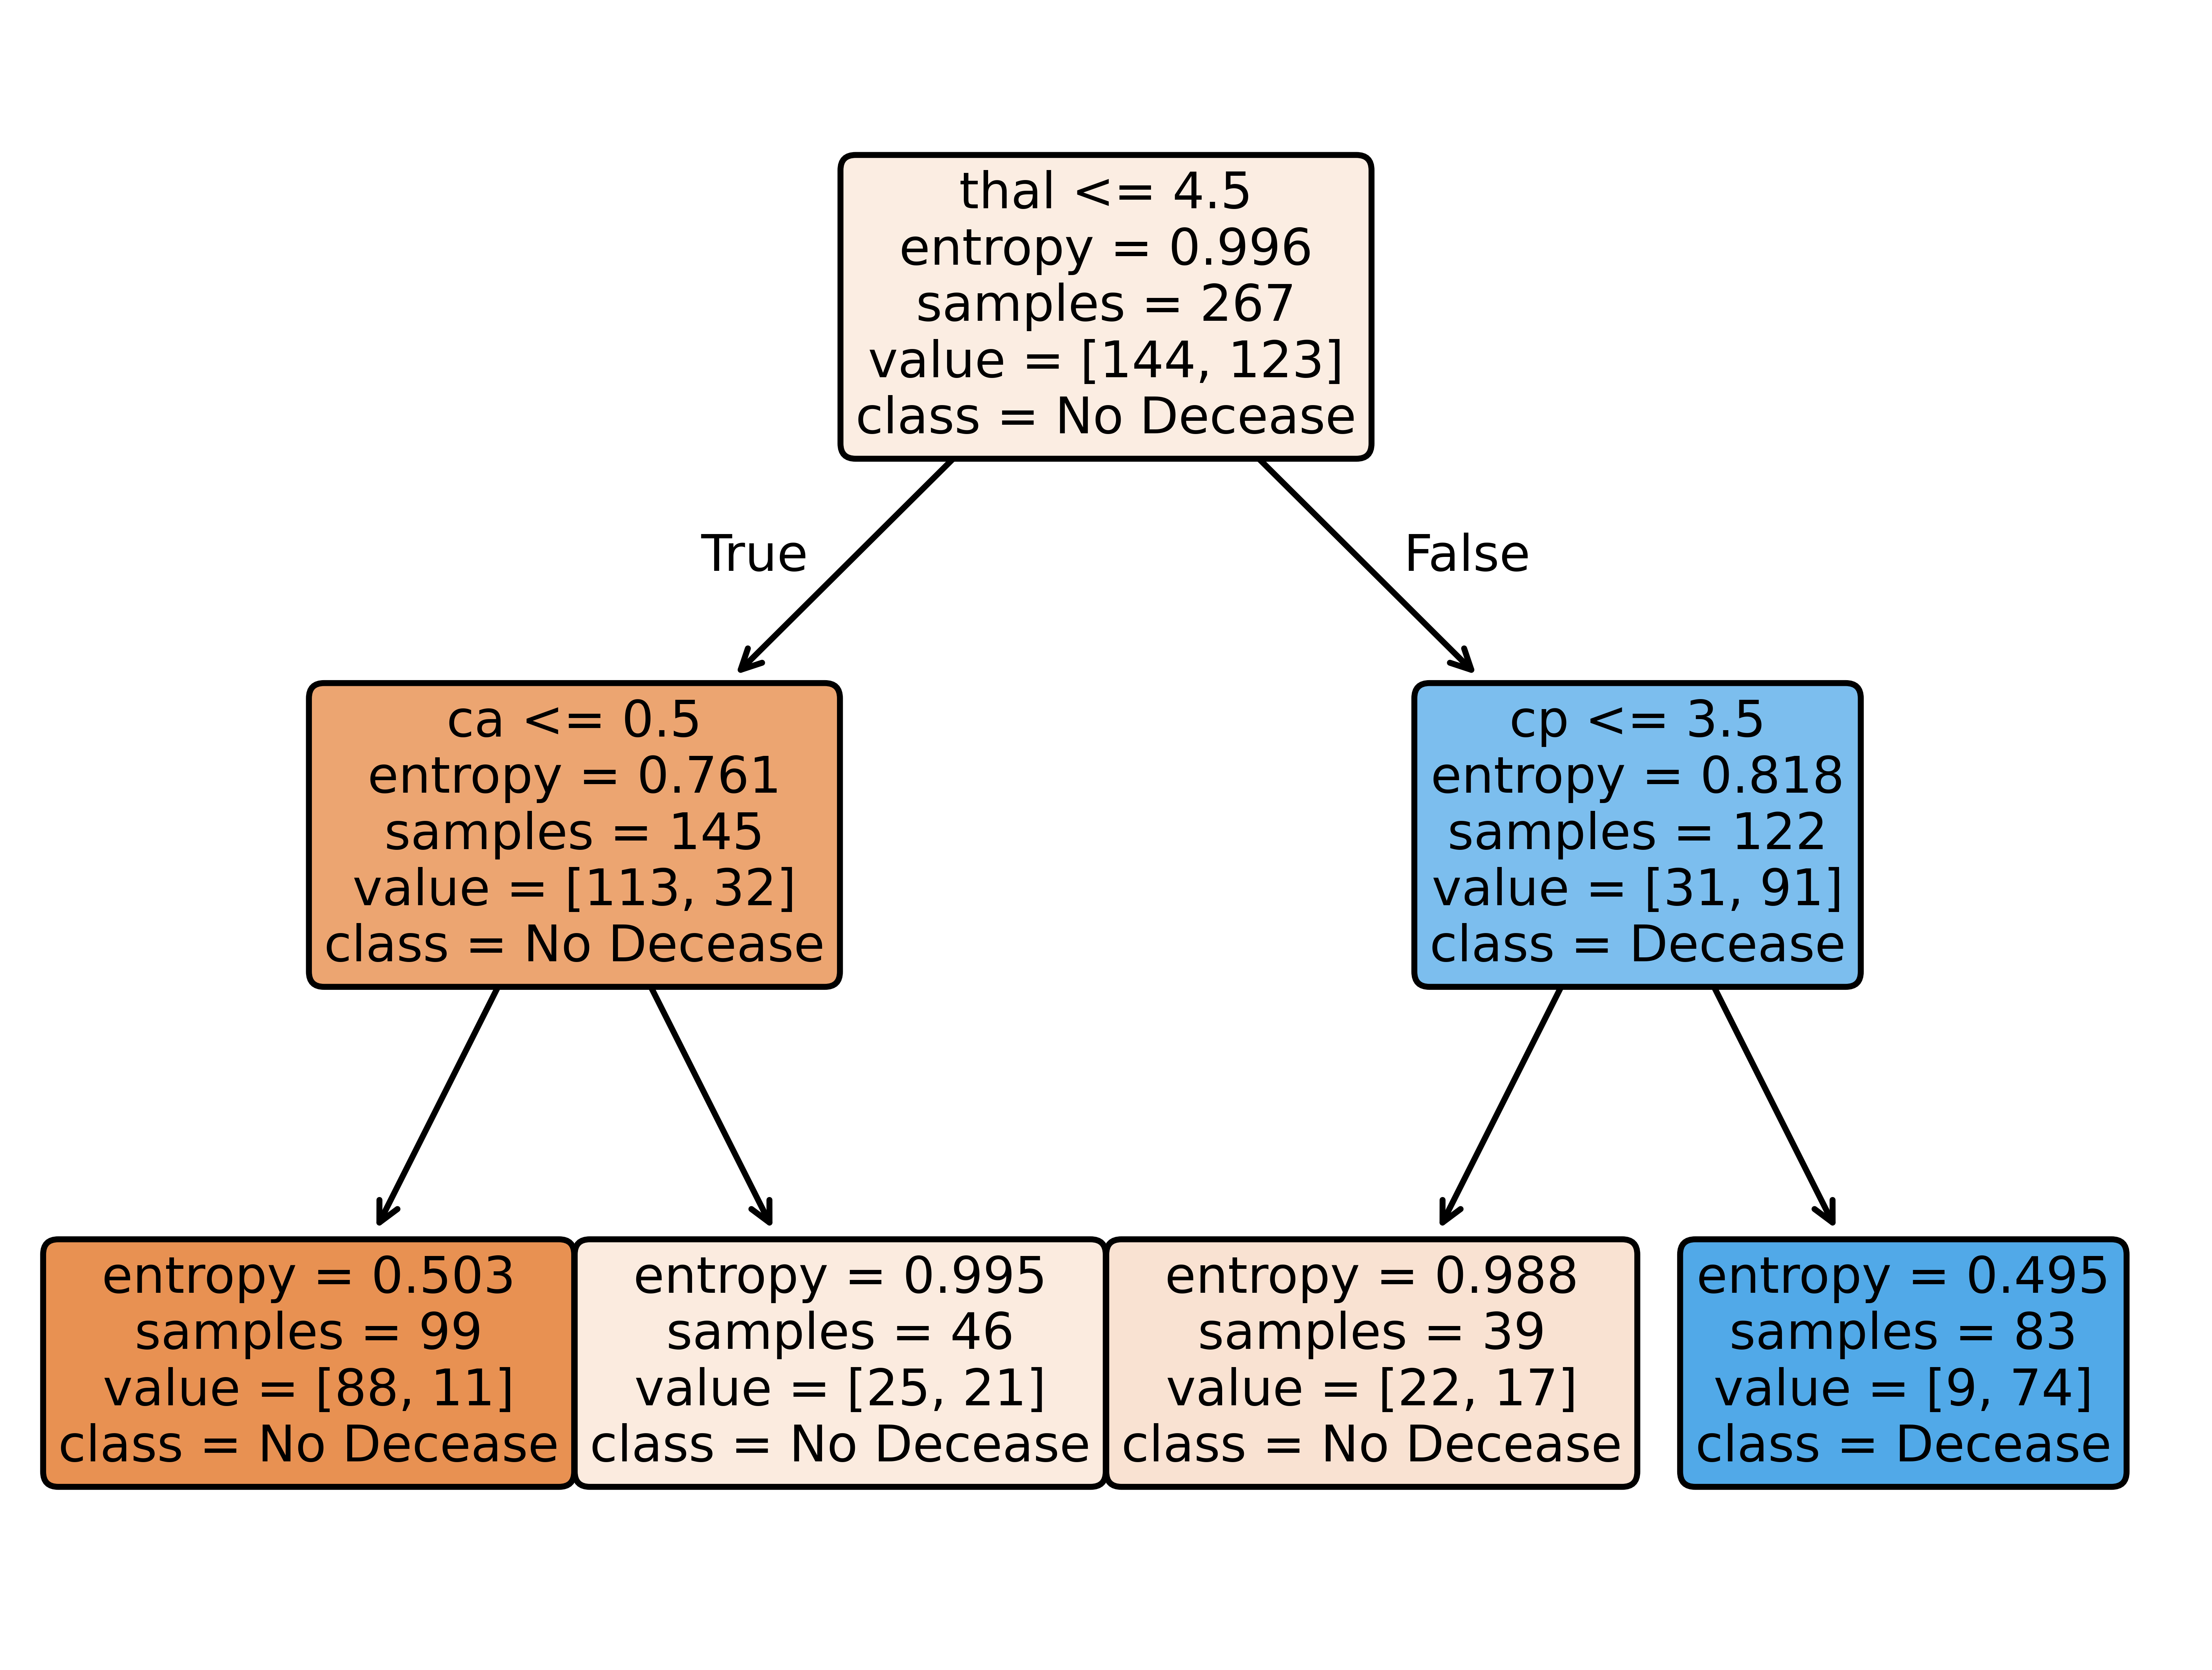


=== Heart Disease Train/Test 90/10 ===
              precision    recall  f1-score   support

  No Decease       0.62      0.94      0.75        16
     Decease       0.83      0.36      0.50        14

    accuracy                           0.67        30
   macro avg       0.73      0.65      0.62        30
weighted avg       0.72      0.67      0.63        30



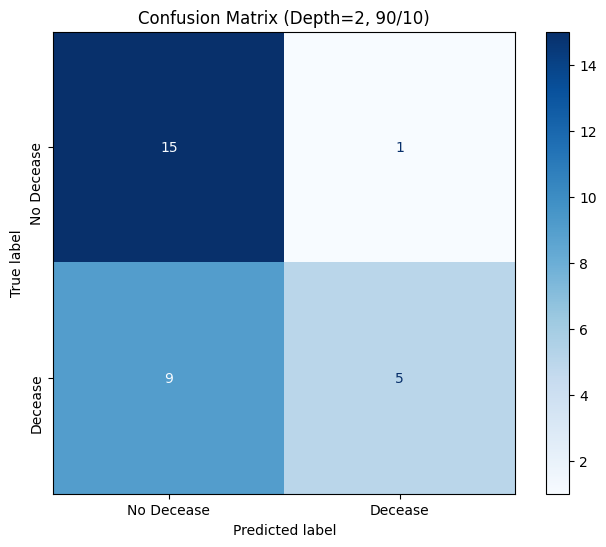

In [5]:
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def run_all_splits():
	for test_size in split_ratios:
		_feature_train, _feature_test, _label_train, _label_test = dataset_splits[test_size]
		dtc = train_and_evaluate(_feature_train, _label_train, max_depth=2)
		plt.figure(dpi=1200)
		plot_tree(dtc, rounded=True, filled=True, feature_names=_feature_train.columns, class_names=class_name)
		plt.show()
		_label_predict = dtc.predict(_feature_test) # predict the label of feature_test based on the tree
		print(f"\n=== {dataset_name} Train/Test {100 - round(test_size * 100)}/{round(test_size * 100)} ===")
		print(classification_report(_label_test, _label_predict, target_names=["No Decease", "Decease"]))

		cm = confusion_matrix(_label_test, _label_predict)
		disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
		fig, ax = plt.subplots(figsize=(8, 6))
		disp.plot(ax=ax, cmap='Blues')
		plt.title(f"Confusion Matrix (Depth=2, {100 - round(test_size * 100)}/{round(test_size * 100)})")
		plt.yticks(rotation=90)
		plt.grid(False)
		plt.show()

run_all_splits()

Max Depth: None
Actual Depth: 11
Accuracy: 0.7667
Saved decision tree visualization: output/depth/heart_disease/heart_disease_80_20_depth_none.svg


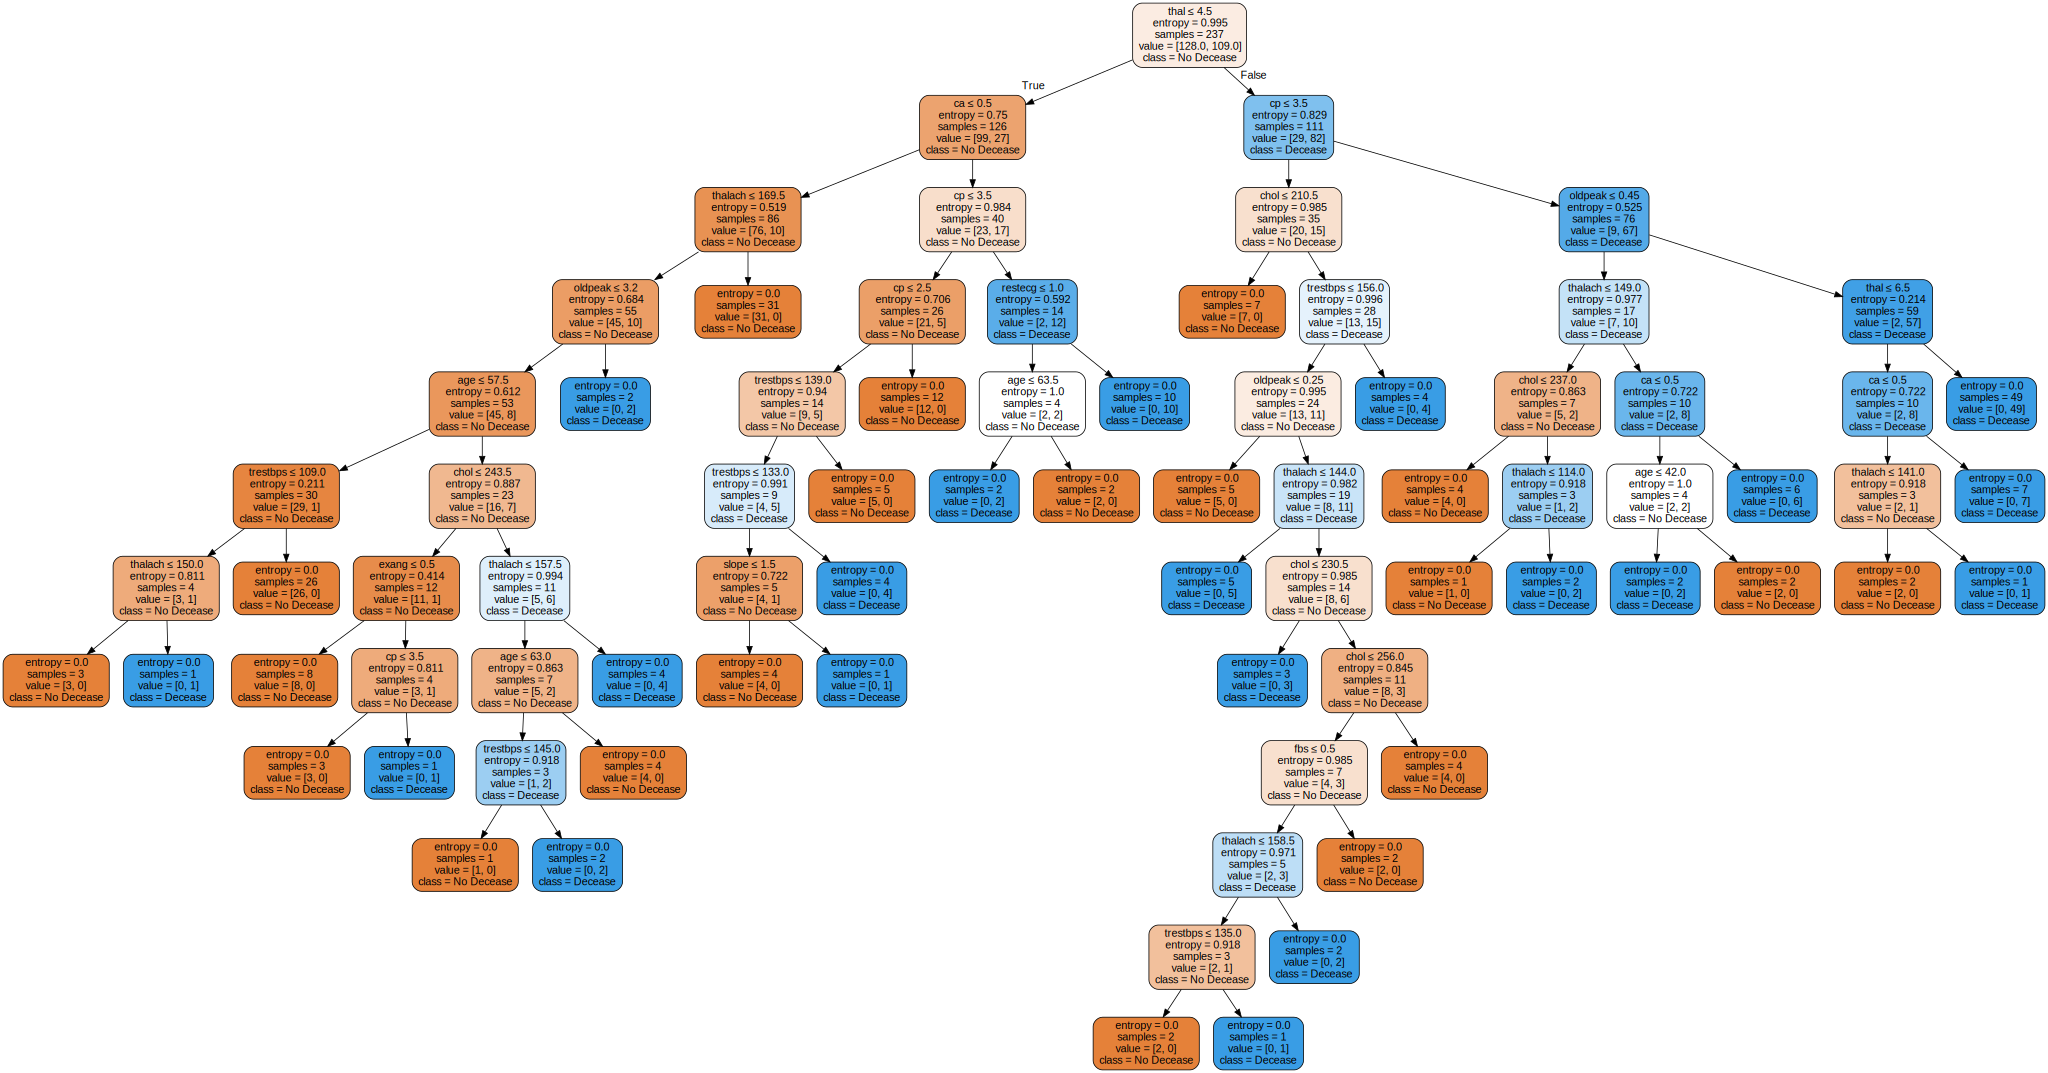

Max Depth: 2
Actual Depth: 2
Accuracy: 0.7167
Saved decision tree visualization: output/depth/heart_disease/heart_disease_80_20_depth_2.svg


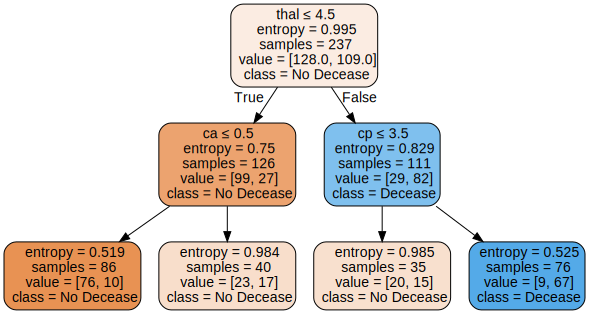

Max Depth: 3
Actual Depth: 3
Accuracy: 0.8167
Saved decision tree visualization: output/depth/heart_disease/heart_disease_80_20_depth_3.svg


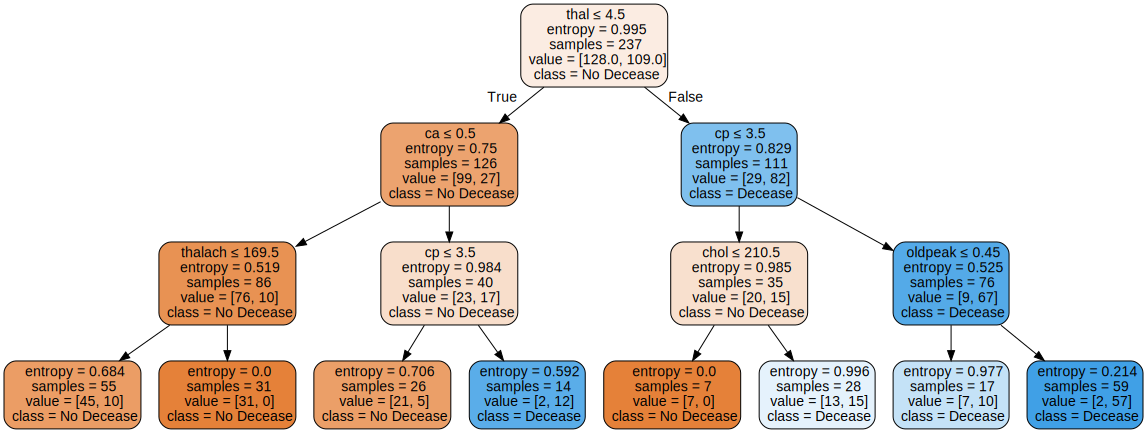

Max Depth: 4
Actual Depth: 4
Accuracy: 0.7667
Saved decision tree visualization: output/depth/heart_disease/heart_disease_80_20_depth_4.svg


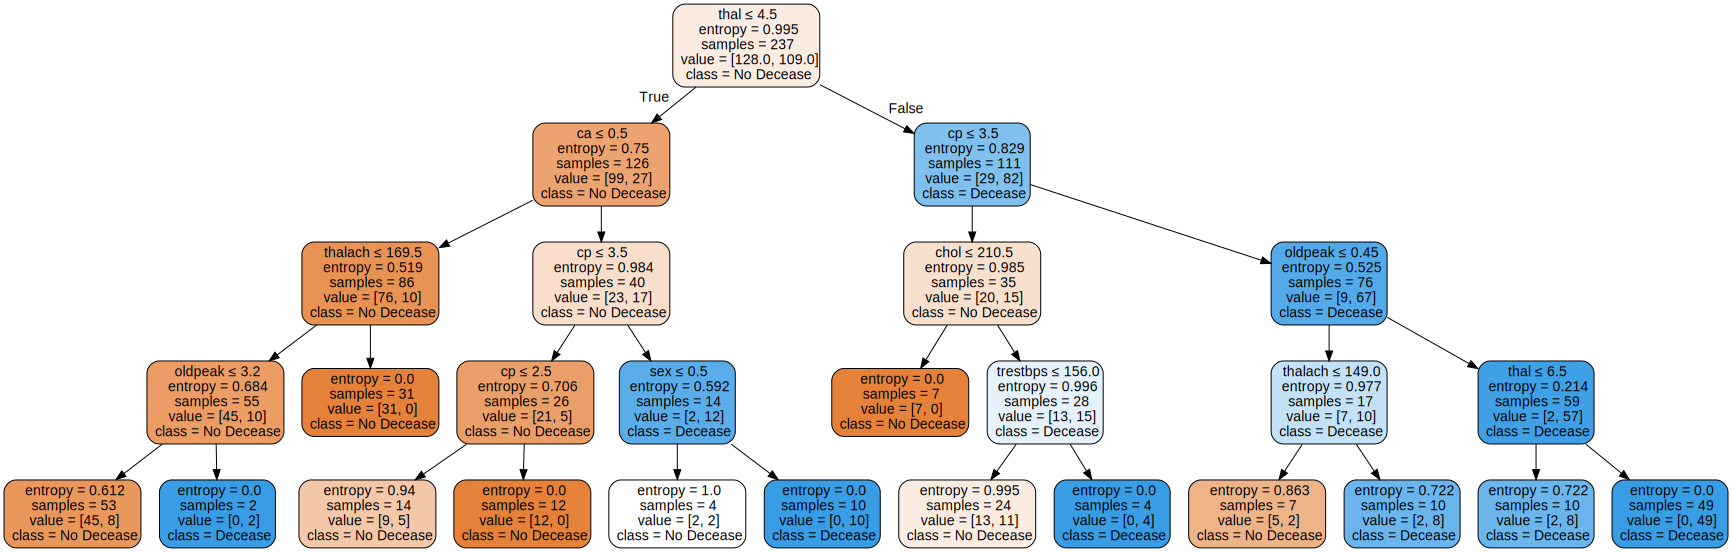

Max Depth: 5
Actual Depth: 5
Accuracy: 0.7667
Saved decision tree visualization: output/depth/heart_disease/heart_disease_80_20_depth_5.svg


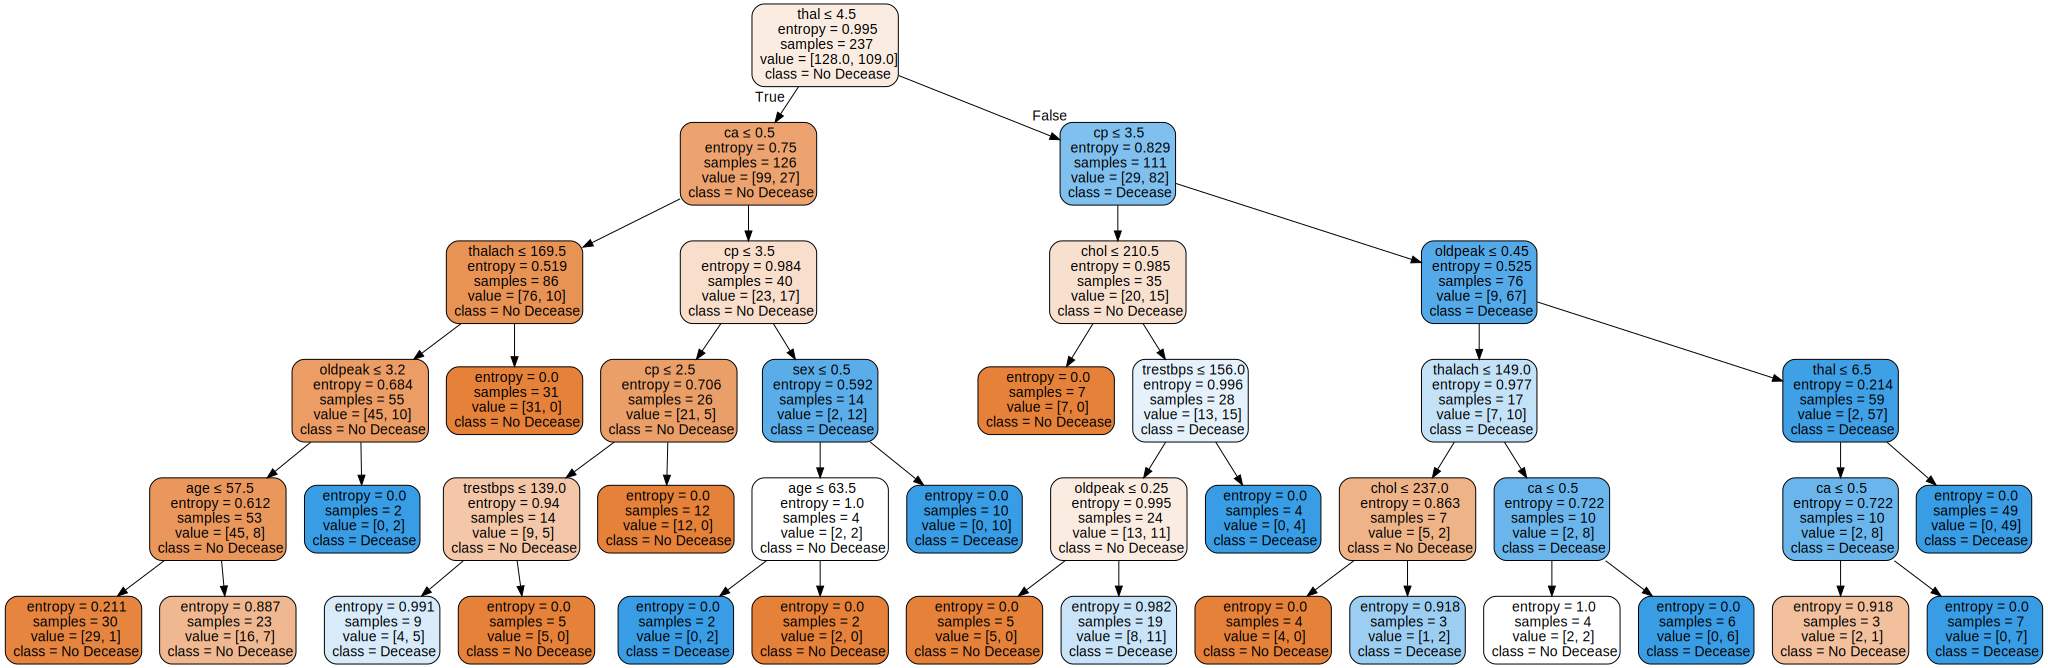

Max Depth: 6
Actual Depth: 6
Accuracy: 0.7333
Saved decision tree visualization: output/depth/heart_disease/heart_disease_80_20_depth_6.svg


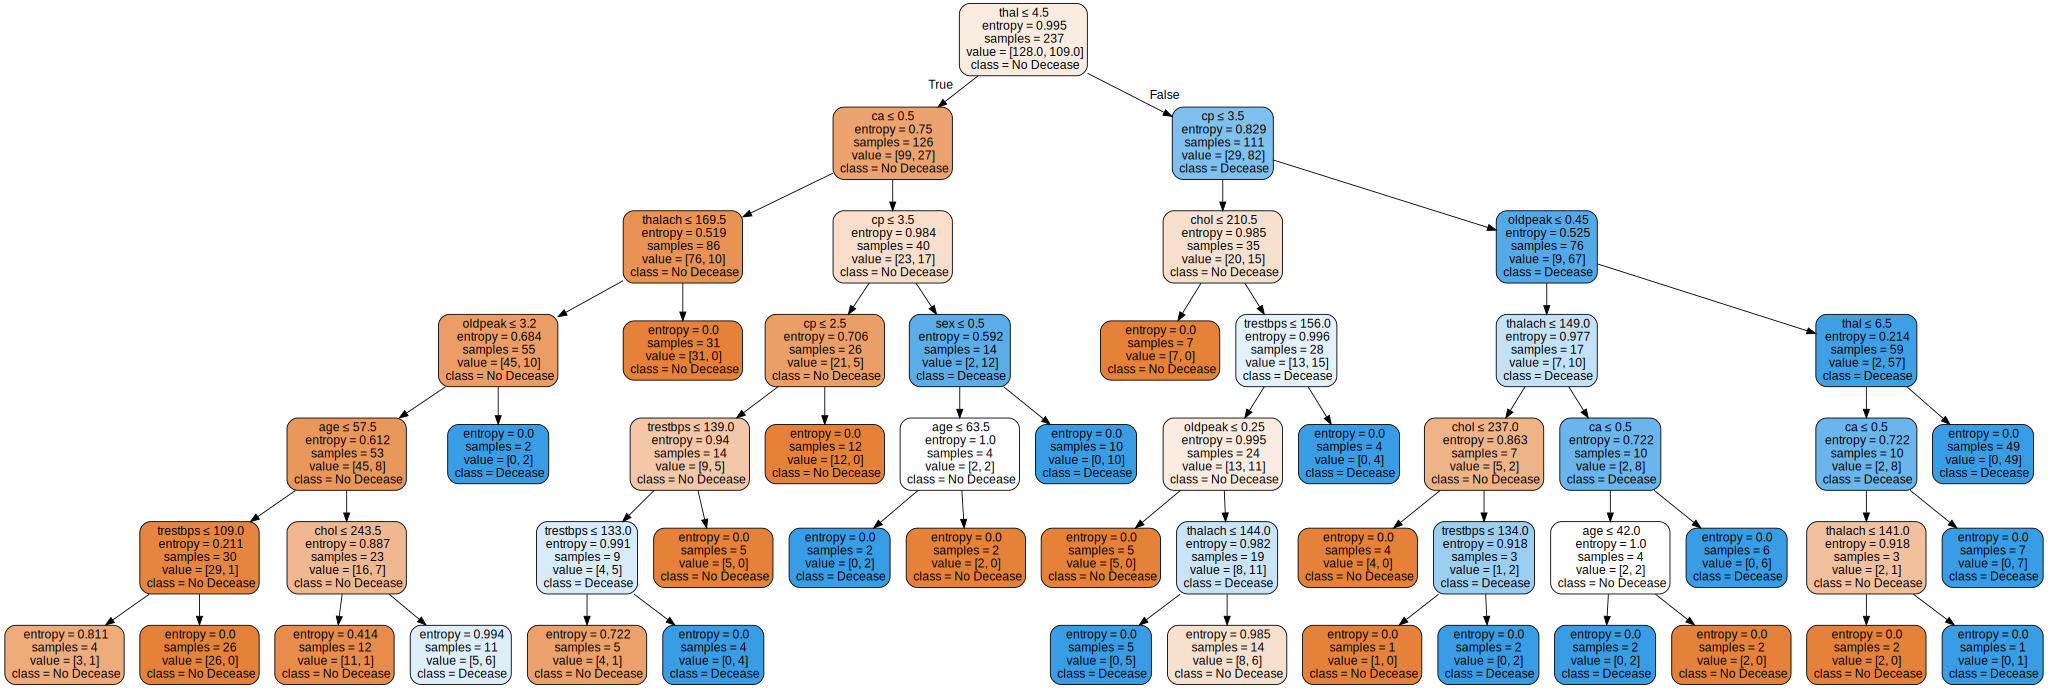

Max Depth: 7
Actual Depth: 7
Accuracy: 0.7667
Saved decision tree visualization: output/depth/heart_disease/heart_disease_80_20_depth_7.svg


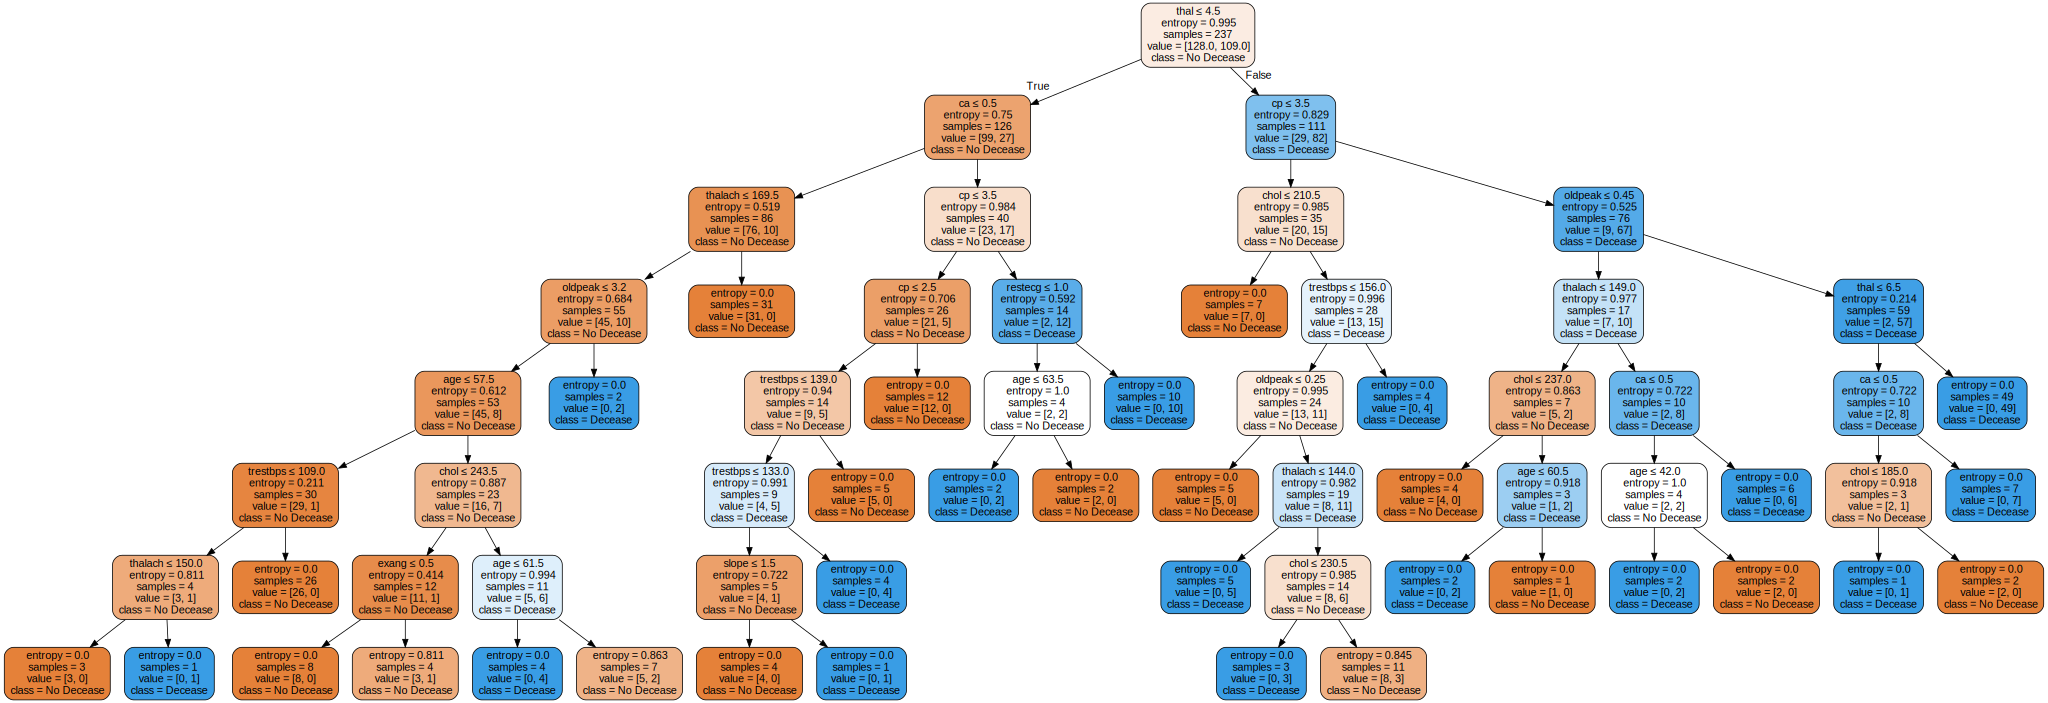

  max_depth  Accuracy
0      None  0.766667
1         2  0.716667
2         3  0.816667
3         4  0.766667
4         5  0.766667
5         6  0.733333
6         7  0.766667


In [54]:
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

def depth_analysis():
	depths = [None, 2, 3, 4, 5, 6, 7]
	accuracies = []

	feature_train, feature_test, label_train, label_test = dataset_splits[0.2]

	with open("output/depth/heart_disease/log.txt", "w") as log_file:
		def tee_print(message, file):
			print(message)                # print to console
			print(message, file=file) # print to log file

		for d in depths:
			# train decision tree with specified max_depth
			dts = train_and_evaluate(feature_train, label_train, max_depth=d)
			result_depth = dts.get_depth()
			label_predict = dts.predict(feature_test)
			acc = accuracy_score(label_test, label_predict)
			accuracies.append(acc)

			tee_print(f"Max Depth: {d}\nActual Depth: {result_depth}\nAccuracy: {acc:.4f}", file=log_file)

			# export decision tree to DOT format
			_dot_data = export_graphviz(dts, feature_names=feature_train.columns, class_names=class_name, filled=True, rounded=True, special_characters=True)
			_graph = graphviz.Source(_dot_data, format="svg")

			def snake_case(s: str) -> str:
				return ''.join('_' if c.isspace() else c.lower() for c in s)

			snake_cased_dataset_name = snake_case(dataset_name)
			_output_file = f"output/depth/{snake_cased_dataset_name}/{snake_cased_dataset_name}_80_20_depth_{d if d is not None else "none"}"
			_graph.render(_output_file, cleanup=True, directory=".")
			tee_print(f"Saved decision tree visualization: {_output_file}.svg", file=log_file)
			display(_graph)

			# from IPython.display import SVG
			# display(SVG(filename=f"{_output_file}.svg"))

			# img = matplotlib.image.imread(f"{output_file}.png")
			# plt.figure(figsize=(12, 6), dpi=300)
			# plt.imshow(img)
			# plt.axis('off') # hide axis for cleaner plot
			# plt.title(f"Decision Tree ({dataset_name}, max_depth={d})")

		# Plot accuracies
		plt.figure(figsize=(10, 6), dpi=150)
		plt.plot([str(d) for d in depths], accuracies, marker='o')
		plt.title(f"Accuracy vs Max Depth ({dataset_name})")
		plt.xlabel("Max Depth")
		plt.ylabel("Accuracy")
		plt.grid()
		plt.savefig(f"accuracy_vs_depth_{dataset_name}.png", dpi=150)
		plt.close()
		accuracy_table = pd.DataFrame({'max_depth': [str(d) for d in depths], 'Accuracy': accuracies})
		tee_print(accuracy_table, file=log_file)

depth_analysis()

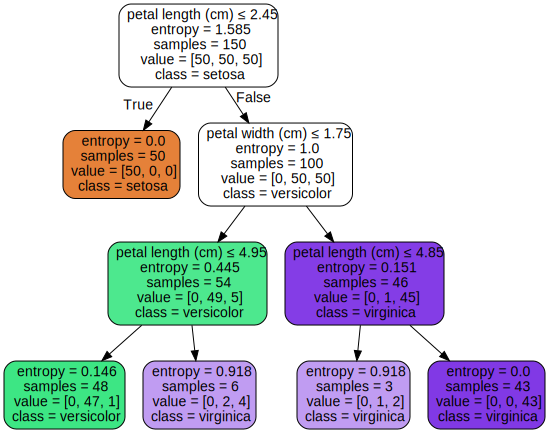

In [44]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from sklearn.datasets import load_iris
from IPython.display import display

# Load dataset (for example, Iris dataset)
data = load_iris()
X = data.data
y = data.target

# Train a decision tree classifier (ID3 - entropy criterion)
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(X, y)

# Export the decision tree as a DOT file
dot_data = export_graphviz(clf, out_file=None,
                           feature_names=data.feature_names,
                           class_names=data.target_names,
                           filled=True, rounded=True,
                           special_characters=True)

# Create a Graphviz Source object to render the DOT
graph = Source(dot_data)

# Display the decision tree
output_file = f"decision_tree_depth.png"
graph.render(output_file, cleanup=True, directory=".")

display(graph)
